In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
%matplotlib inline

# Reading the raw data from the files
* raw data registered by accelerometer and gyroscope in the smartphone
* preparing a dictionary with DataFrames  for each experiment

In [2]:
#Sorting file names in the data folder
file_names = sorted(glob.glob('RawData/*'))

In [3]:
# Making a raw data dictionary for each experiment
raw_dic = {}

for n in range(61):
    
    # Keys: expXX_userYY where XX number of experiment and YY user's ID
    key = file_names[n][12:24]
    
    # DataFrames with the data for the accelerometer and gyroscope
    raw_acc = pd.read_csv(file_names[n], sep = ' ', header = None, names = ['acc_x','acc_y','acc_z'])
    raw_gyr = pd.read_csv(file_names[n+61], sep = ' ', header = None, names = ['gyr_x','gyr_y','gyr_z'])
    
    # Dictionary with both DataFrames
    raw_dic[key] = pd.concat([raw_acc,raw_gyr],axis = 1)

In [4]:
# Example of the raw DataFrame
raw_dic['exp01_user01'].head(3)

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z
0,0.918056,-0.112500,0.509722,-0.054978,-0.069639,-0.030849
1,0.911111,-0.093056,0.537500,-0.012523,0.019242,-0.038485
2,0.881944,-0.086111,0.513889,-0.023518,0.276417,0.006414


# Reading the file with labels
* preparing the DataFrame with all labels which describe signals

In [5]:
# DataFrame with database labels
labels = pd.read_csv('RawData/labels.txt', sep=' ', header = None, names = ['Exp_ID','Us_ID','Act_ID','Start_Point','End_Point'] )

In [6]:
# Info about labels DataFrame
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1214 entries, 0 to 1213
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Exp_ID       1214 non-null   int64
 1   Us_ID        1214 non-null   int64
 2   Act_ID       1214 non-null   int64
 3   Start_Point  1214 non-null   int64
 4   End_Point    1214 non-null   int64
dtypes: int64(5)
memory usage: 47.5 KB


In [7]:
labels.head(3)

,Exp_ID,Us_ID,Act_ID,Start_Point,End_Point
0,1,1,5,250,1232
1,1,1,7,1233,1392
2,1,1,4,1393,2194


# Signals visualisation
* initializing a function to visualize signals from gyroscope and acceleroemeter

In [16]:
# Sampling frequency in this database is 50 Hz 
fs = 50 #Hz

# Function: visualisation all signal for one experiment
def all_data_visual (dataframe, sig):
   
    # Time list where sampling freq = 50 Hz 
    time = [1/(fs) * t for t in range(len(dataframe))]
    if sig == 'acc':
        # ALL Accelerometer signals (X, Y, Z) visualisation
        fig = plt.figure(figsize=(15,5))
        plt.plot(time,dataframe['acc_x'],color = 'c', label= 'acc_x', alpha=0.7)
        plt.plot(time,dataframe['acc_y'],color = 'm', label= 'acc_y', alpha=0.7)
        plt.plot(time,dataframe['acc_z'],color = 'y', label= 'acc_z', alpha=0.7)
        plt.title('Acceleration Signals', fontsize=19)
        plt.xlabel('Time [s]', fontsize=17)
        plt.xticks(fontsize=17)
        plt.ylabel('Acceleration [1g]', fontsize=17)
        plt.yticks(fontsize=17)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=17)
        plt.grid(color='grey', linestyle='--', linewidth=0.2)
    elif sig == 'gyr':
        # ALL Gyroscope signals (X, Y, Z) visualisation
        fig = plt.figure(figsize=(15,5))
        plt.plot(time,dataframe['gyr_x'],color = 'c', label= 'gyr_x', alpha=0.9)
        plt.plot(time,dataframe['gyr_y'],color = 'm', label= 'gyr_y', alpha=0.9)
        plt.plot(time,dataframe['gyr_z'],color = 'y', label= 'gyr_z', alpha=0.9)
        plt.title('Gyroscope Signals',fontsize=19)
        plt.xlabel('Time [s]',fontsize=17)
        plt.xticks(fontsize=17)
        plt.ylabel('Angular Velocity [rad/s]',fontsize=17)
        plt.yticks(fontsize=17)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=17)
        plt.grid(color='grey', linestyle='--', linewidth=0.2)
    else:
        print("Wrong command. Please use: 'acc' or 'gyr'")

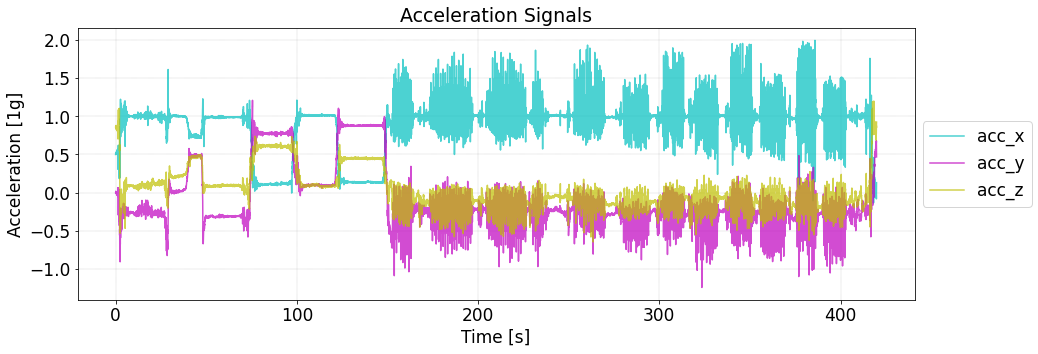

In [17]:
all_data_visual(raw_dic['exp05_user03'],'acc')

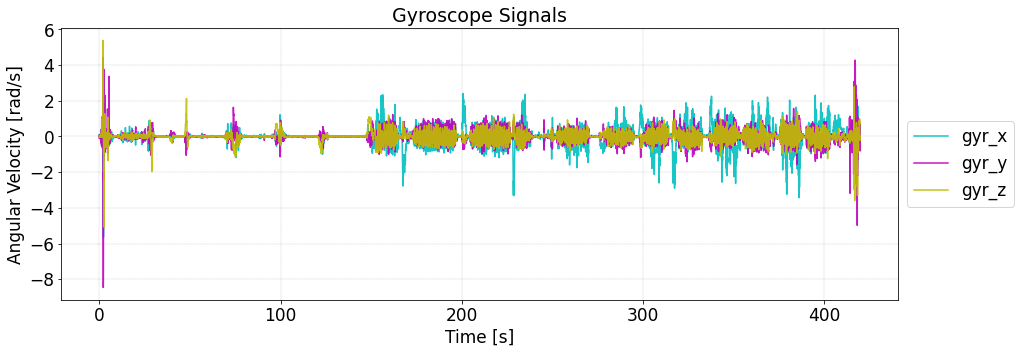

In [15]:
all_data_visual(raw_dic['exp05_user03'],'gyr')

# Time signal preprocessing

** Noise filtering: median filter, 3rd order low-pass Butterworth filter, lowpass filter to separate body n gravity components **

In [18]:
# Import functions from scipy.signal
from scipy.signal import medfilt, butter, filtfilt

In [45]:
# Function for visualisation the signal to check filtering
def visualisation(signal,title):
    
    # Counting a time from the number of samples (fs = 50 Hz)
    time = [1/(fs) * t for t in range(len(signal))]
    # Drawing a plot
    fig = plt.figure(figsize=(15,5))
    plt.plot(time,signal,color = 'c')
    plt.title(title,fontsize=19)
    plt.xlabel('Time [s]',fontsize=17)
    plt.xticks(fontsize=17)
    plt.ylabel('Signal value',fontsize=17)
    plt.yticks(fontsize=17)
    plt.grid(color='grey', linestyle='--', linewidth=0.2)

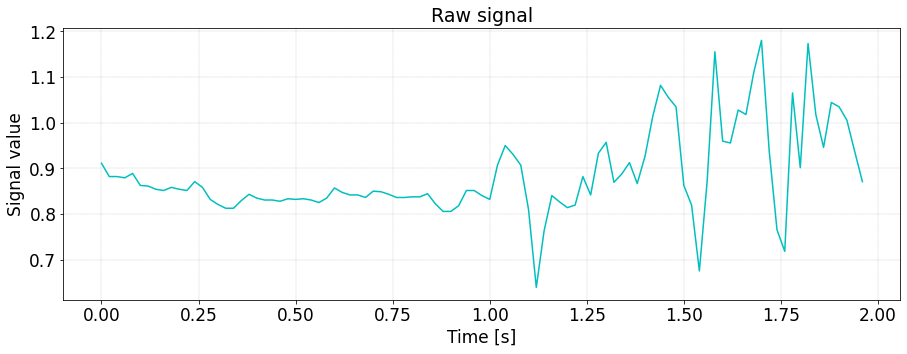

In [46]:
# The raw signal visualisation
visualisation(raw_dic['exp01_user01']['acc_x'][1:100], 'Raw signal')

In [47]:
# Median filter
def median_filter(raw_signal):
    
    # Changing the signal data into array
    arr_signal = np.array(raw_signal)
    # Using a median filter on the raw signal data
    m_signal = medfilt(arr_signal)
    
    return m_signal # return the array of filtered signal

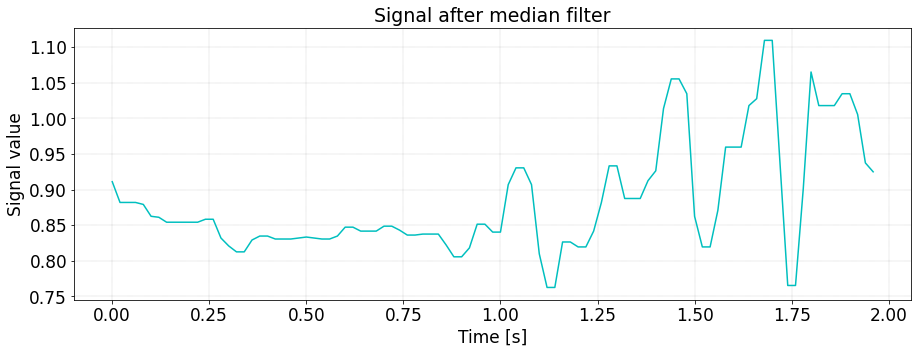

In [48]:
# Median filtered signal visualisation
med_signal = median_filter(raw_dic['exp01_user01']['acc_x'])
visualisation(med_signal[1:100],'Signal after median filter')

In [49]:
# Function with 3rd order low-pass Butterworth filter (cutoff = 20Hz - cut-off freq.) to reduce the noise
cutoff= 20  # Cut-off frequency of the filter
W = cutoff/(fs/2) # Normalizing the frequency

def butterworth3rd(m_singal):
    
    # Preparing the low-pass filter
    b, a = butter(3, W, 'low')
    # Using a filter on the signal 
    output = filtfilt(b, a, m_singal)
    
    return output

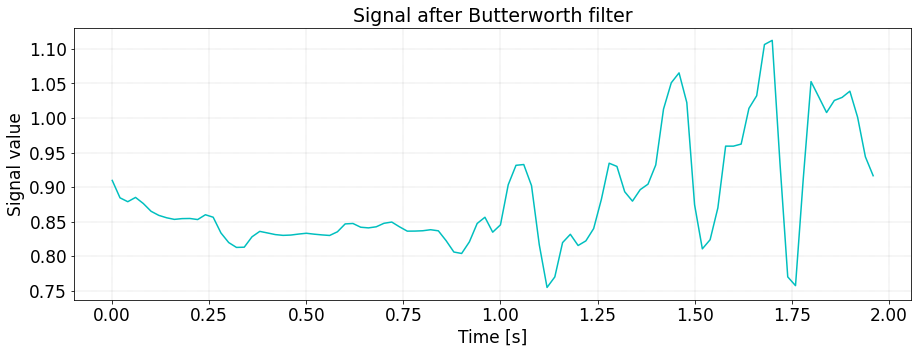

In [50]:
# The signal after 3rd order low-pass Butterworth filter visualisation
butt_signal = butterworth3rd(med_signal)
visualisation(butt_signal[1:100],'Signal after Butterworth filter')

In [51]:
# Import functions for FFT and iFFT
from scipy.fftpack import fft, fftfreq, ifft
import math

In [52]:
# Function with the filter to separate the signal into body and gravity component
def def butterworth(signal)::
    
    # Changing the signal data into the array
    arr_signal = np.array(signal)
    # Using FFT to convert the time singal into the freqency signal
    f_signal = fft(arr_signal)
    # Generating frequencies where the sampling frequency is 50 Hz
    freq = fftfreq(len(arr_signal), d = 1/fs)
    # Copying all frequency signal to gravity and body arrays
    f_grav_signal = f_signal.copy()
    f_body_signal = f_signal.copy()
    # Put null when the signal frequency is above the 0.3 Hz - gravity component
    f_grav_signal[(abs(freq) > 0.3)] = 0
    # Put null when the signal frequency is under the 0.3 Hz - body component
    f_body_signal[(abs(freq) <= 0.3)] = 0
    
    # iFFT to receive real time signals after the filtering
    t_grav_signal = ifft(f_grav_signal).real
    t_body_signal = ifft(f_body_signal).real
    
    return t_body_signal, t_grav_signal

In [53]:
# Checking the function
tBodyAcc_x, tGravityAcc_x = butterworth(butt_signal)

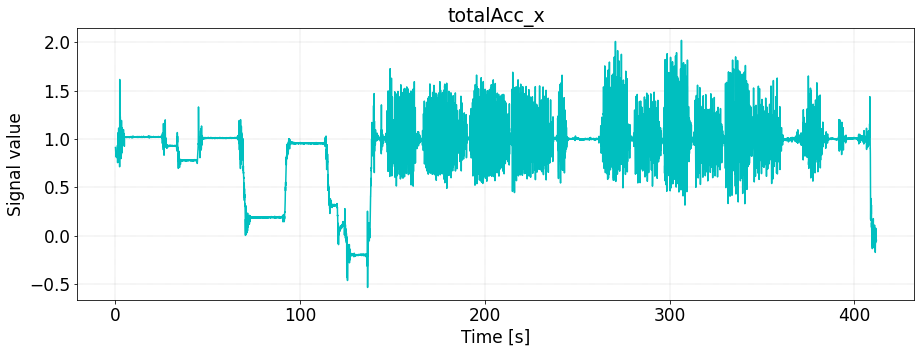

In [62]:
# Total signal visualisation
visualisation(butt_signal,'totalAcc_x')

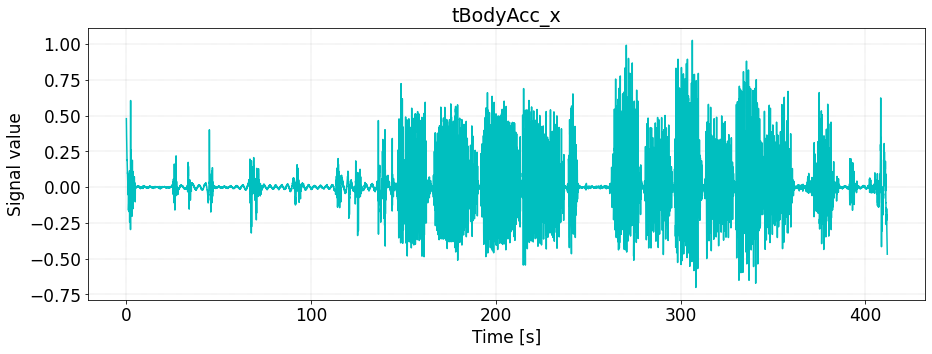

In [55]:
# The body component visualisation
visualisation(tBodyAcc_x,'tBodyAcc_x')

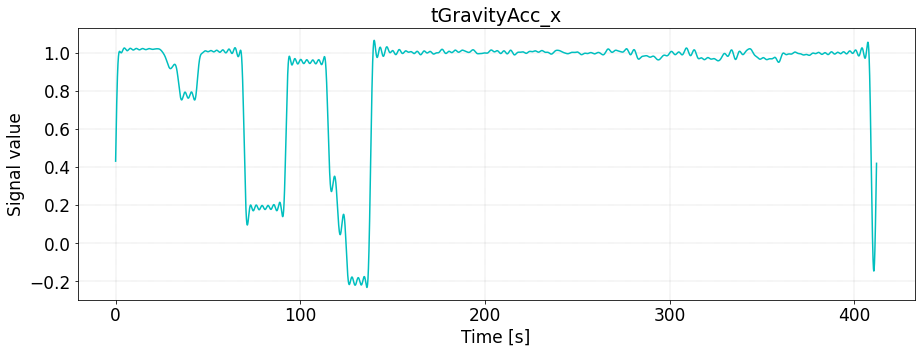

In [56]:
# The gravity component visualisation
visualisation(tGravityAcc_x,'tGravityAcc_x')

In [57]:
# Function: the jerk signal (da/dt) where: da = d(signal) and dt=1/fs
def jerk_signal(signal):
    
    # Counting the jerk signal 
    jerk = [(signal[i+1]-signal[i])/(1/fs) for i in range(len(signal)-1)]
    # Converting into np.array and return jerk
    return np.array(jerk)

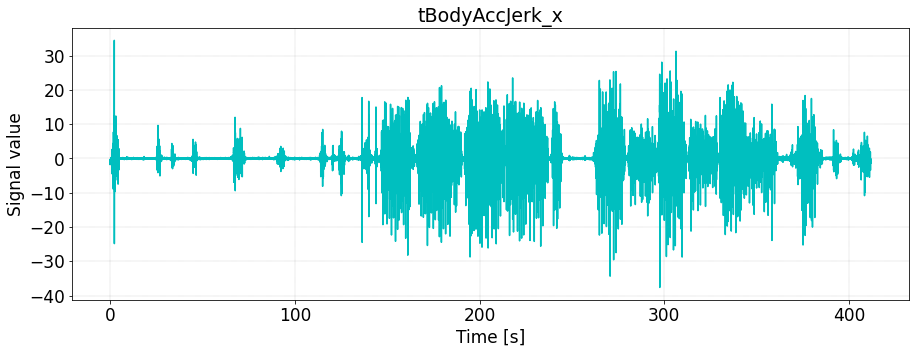

In [58]:
# The jerk signal: tBodyAccJerk_x vizualization
tBodyAccJerk_x = jerk_signal(tBodyAcc_x)
vizualization(tBodyAccJerk_x, 'tBodyAccJerk_x')

In [59]:
# Function: the euclidean magnitude 
def magnitude(signal_x, signal_y, signal_z):
    
    # Counting the euclidean magnitude
    mag = [math.sqrt(signal_x[i]**2 + signal_y[i]**2 + signal_z[i]**2) for i in range(len(signal_x))]
    # Returning the array 
    return np.array(mag)

In [60]:
# Just checking if magnitude function is working correctly
med_signal2 = median_filter(raw_dic['exp01_user01']['acc_y'])
med_signal3 = median_filter(raw_dic['exp01_user01']['acc_z'])

In [38]:
butt_signal2 = butterworth3rd(med_signal2)
butt_signal3 = butterworth3rd(med_signal3)

In [39]:
tGravityAcc_y = butterworth(butt_signal2)[1]
tGravityAcc_z = butterworth(butt_signal3)[1]

In [40]:
tGravityAccMag = magnitude(tGravityAcc_x,tGravityAcc_y,tGravityAcc_z)

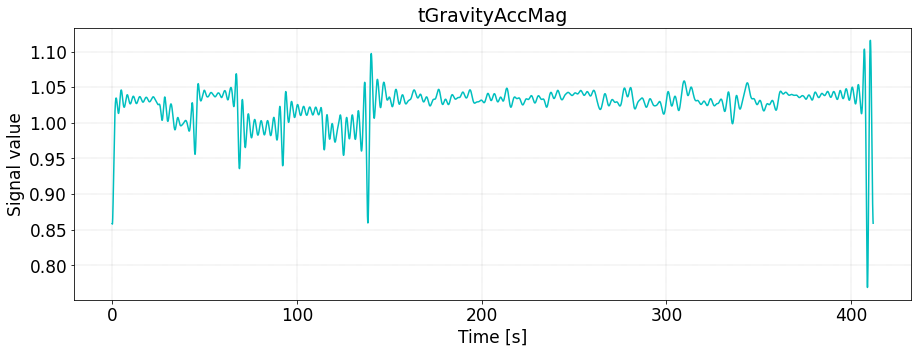

In [61]:
# Gravity signal after using the euclidean magnitude
visualisation(tGravityAccMag,'tGravityAccMag')

In [42]:
# Function to preprocessing all compontents of acceleration and gryoscope signals
def time_processing(data):
    
    # DataFrame for collecting time informations from signals
    time_df = pd.DataFrame()
   
    # Processing first 3 columns from the raw database containing acc signals
    for label in data.columns[0:3]:
        # Using all designed filters
        med_sig = median_filter(data[label])
        butt_sig = butterworth3rd(med_sig)
        body, gravity = butterworth(butt_sig)
        # Deleting last row of datas to fit the size with jerk and magnitude datas
        time_df['tBodyAcc_'+label[4]] = body[:-1] # body component
        time_df['tGravityAcc_'+label[4]] = gravity[:-1] # gravity component
        time_df['tBodyAccJerk_'+label[4]] = jerk_signal(body) # body jerk data
    # magnitude data for body, gravity and body jerk
    time_df['tBodyAccMag'] = magnitude(time_df['tBodyAcc_x'],time_df['tBodyAcc_y'],time_df['tBodyAcc_z'])
    time_df['tGravityAccMag'] = magnitude(time_df['tGravityAcc_x'],time_df['tGravityAcc_y'],time_df['tGravityAcc_z'])
    time_df['tBodyAccJerkMag'] = magnitude(time_df['tBodyAccJerk_x'],time_df['tBodyAccJerk_y'],time_df['tBodyAccJerk_z'])
    
    # Processing next 3 columns from the raw database containing gyro signals: same algorythms but without gravity component
    for label in data.columns[3:6]:
        med_sig = median_filter(data[label])
        butt_sig = butterworth3rd(med_sig)
        body, _ = butterworth(butt_sig)
        time_df['tBodyGyro_'+label[4]] = body[:-1]
        time_df['tBodyGyroJerk_'+label[4]] = jerk_signal(body)
        
    time_df['tBodyGyroMag'] = magnitude(time_df['tBodyGyro_x'],time_df['tBodyGyro_y'],time_df['tBodyGyro_z'])
    time_df['tBodyGyroJerkMag'] = magnitude(time_df['tBodyGyroJerk_x'],time_df['tBodyGyroJerk_y'],time_df['tBodyGyroJerk_z'])
    
    # Preparing new time dataframe with stacked columns
    columns = ['tBodyAcc_x', 'tBodyAcc_y', 'tBodyAcc_z', 'tGravityAcc_x', 'tGravityAcc_y',
               'tGravityAcc_z', 'tBodyAccJerk_x', 'tBodyAccJerk_y', 'tBodyAccJerk_z', 
               'tBodyGyro_x', 'tBodyGyro_y', 'tBodyGyro_z', 'tBodyGyroJerk_x', 'tBodyGyroJerk_y',
               'tBodyGyroJerk_z', 'tBodyAccMag', 'tBodyAccJerkMag', 'tGravityAccMag', 'tBodyGyroMag',
               'tBodyGyroJerkMag']
    
    new_time_df = time_df[columns]
    
    return new_time_df

In [43]:
# Creating the dictionary included dataframes with time signals datas for all experiments 
time_dic = {}
# Signal preprocessing for each number of the experiment
time_dic = {key: time_processing(raw_dic[key]) for key in raw_dic.keys()}

In [44]:
time_dic['exp01_user01'].head(4)

,tBodyAcc_x,tBodyAcc_y,tBodyAcc_z,tGravityAcc_x,tGravityAcc_y,tGravityAcc_z,tBodyAccJerk_x,tBodyAccJerk_y,tBodyAccJerk_z,tBodyGyro_x,tBodyGyro_y,tBodyGyro_z,tBodyGyroJerk_x,tBodyGyroJerk_y,tBodyGyroJerk_z,tBodyAccMag,tBodyAccJerkMag,tGravityAccMag,tBodyGyroMag,tBodyGyroJerkMag
0,0.479343,-0.268985,-0.211078,0.431752,0.175976,0.720853,-0.638599,0.308263,0.493683,-0.018597,-0.188308,-0.370108,0.117593,1.687197,0.123715,0.588792,0.864035,0.858491,0.415675,1.695809
1,0.466571,-0.262820,-0.201204,0.443080,0.169277,0.715091,-1.822817,0.751758,0.284237,-0.016245,-0.154564,-0.367634,-0.216635,11.536347,1.430880,0.572054,1.992133,0.858097,0.399135,11.626764
2,0.430114,-0.247785,-0.195519,0.454370,0.162555,0.709287,-0.842608,0.236261,0.314607,-0.020578,0.076163,-0.339016,-2.132414,6.837342,0.385436,0.533501,0.929938,0.857883,0.348075,7.172517
3,0.413262,-0.243060,-0.189227,0.465616,0.155814,0.703438,-0.250197,-0.243066,0.182193,-0.063226,0.212909,-0.331307,-0.957783,3.561483,-1.480256,0.515432,0.393540,0.857847,0.398864,3.973999


# Using fixed-width sliding windows on the time signal

* Windowing the time signal with a span of 2.56 sec (2.56sec × 50Hz = 128 cycles) and an overlap of 50%.

In [63]:
# Describing indexes of activities in the dictionary
act_numbers = {1: 'WALKING',           
2: 'WALKING_UPSTAIRS',  
3: 'WALKING_DOWNSTAIRS',
4: 'SITTING',           
5: 'STANDING',          
6: 'LAYING',            
}

In [64]:
# Windowing the time signal 
def time_signal_windowing(time_dic, labels):
    # Creating a dictionary for each window with a keys: 'expAA_us_BB_act_C_D' where AA - experiment id, BB - user id, 
    # C - activity id, D - window id
    win_time_dic = {}
    # Using only activities with index 1 - 6, postural transitions are not included
    sorted_labels =np.array(labels[labels['Act_ID'] < 7])
    # Window id, first is 0
    win_id = 0
    # Taking each sample from labels
    for sample in sorted_labels:
        # When id numbers are less then 10, add 0 before 
        if sample[0] < 10:
            key_exp = '0' + str(sample[0])
        else:
            key_exp = str(sample[0])
        if sample[1] < 10:
            key_us = '0' + str(sample[1])
        else:
            key_us = str(sample[1])  
        # Creating keys to use right dataframes for the user and the experiment number
        key = 'exp' + key_exp + '_user' + key_us
        # Start_Point from the sample
        start = sample[3]
        # End_Point
        end = sample[4]
        # Act_ID
        act_id = str(sample[2])
        # Windowing a signal described by the sample (from startpoint to endpoint), where the step is 128/2 = 64
        # bc the overlap is 50%
        for start_point in range(start,end - 127,64):
            # Window size 128 cycles
            end_point = start_point + 127
            # Creating a key for the windows dictionary
            key_win = key + '_act' + act_id + '_' + str(win_id)
            # Windowing the signal data
            win_time_dic[key_win] = time_dic[key][start_point:end_point + 1]
            # Increasing the window id
            win_id+=1
    # Returning the windowing time signal dicionary        
    return win_time_dic

In [65]:
# Windowing the time signal
win_time_dic = time_signal_windowing(time_dic,labels)

In [66]:
# Windows of the time signal visualisation
win_time_dic['exp01_user01_act5_0']

,tBodyAcc_x,tBodyAcc_y,tBodyAcc_z,tGravityAcc_x,tGravityAcc_y,tGravityAcc_z,tBodyAccJerk_x,tBodyAccJerk_y,tBodyAccJerk_z,tBodyGyro_x,tBodyGyro_y,tBodyGyro_z,tBodyGyroJerk_x,tBodyGyroJerk_y,tBodyGyroJerk_z,tBodyAccMag,tBodyAccJerkMag,tGravityAccMag,tBodyGyroMag,tBodyGyroJerkMag
250,-0.004118,0.009994,-0.049204,1.025297,-0.135052,0.153468,-0.004192,0.023488,0.003252,0.020283,0.078939,0.053122,0.128699,0.568826,-0.058207,0.050378,0.024080,1.045479,0.097286,0.586101
251,-0.004202,0.010464,-0.049139,1.025123,-0.135542,0.152980,-0.013093,0.035317,0.062967,0.022857,0.090315,0.051957,0.358132,0.150105,-0.307336,0.050416,0.073373,1.045300,0.106672,0.495223
252,-0.004464,0.011170,-0.047880,1.024940,-0.136014,0.152418,-0.089888,0.006799,0.208508,0.030020,0.093317,0.045811,0.059877,0.270736,-0.069546,0.049368,0.227160,1.045099,0.108203,0.285867
253,-0.006262,0.011306,-0.043710,1.024747,-0.136467,0.151784,-0.028508,-0.103912,0.051407,0.031217,0.098732,0.044420,-0.182238,0.292148,0.162975,0.045580,0.119387,1.044877,0.112675,0.380949
254,-0.006832,0.009228,-0.042682,1.024545,-0.136900,0.151080,0.036075,0.013590,-0.166983,0.027573,0.104575,0.047679,-0.048620,0.099673,0.284044,0.044199,0.171375,1.044634,0.118193,0.304925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,-0.004401,-0.013669,0.001103,1.022534,-0.110934,0.100161,0.055430,0.124824,-0.181486,0.055758,-0.093806,-0.032201,-0.247852,0.127929,0.172505,0.014403,0.227135,1.033399,0.113778,0.327955
374,-0.003293,-0.011173,-0.002526,1.022708,-0.111246,0.101207,0.131005,0.092616,-0.256861,0.050801,-0.091247,-0.028751,-0.166795,0.071335,0.201219,0.011919,0.302850,1.033707,0.108321,0.270922
375,-0.000673,-0.009321,-0.007664,1.022877,-0.111574,0.102238,-0.004775,0.035699,-0.219948,0.047465,-0.089821,-0.024727,-0.127893,0.102978,0.072130,0.012085,0.222877,1.034011,0.104557,0.179343
376,-0.000768,-0.008607,-0.012062,1.023040,-0.111917,0.103254,-0.014314,-0.021454,0.019666,0.044907,-0.087761,-0.023284,-0.353055,0.237449,0.187280,0.014838,0.032434,1.034310,0.101296,0.464869


In [67]:
# Function to generate output general data: with numbers of activities ID for each window and each sample in this window
def lab_data(data):
    # Getting keys from the dictionary with the windowing signal
    keys = data.keys()
    # General dataframe with all act id for each window
    label_df = pd.DataFrame()
    # Dataframe to put ID value for one window
    act_df = pd.DataFrame()
    for key in keys:
        act_df['Act_ID'] = [key[16]]
        label_df = pd.concat([label_df,act_df],axis=0, ignore_index=True)
    return label_df

In [68]:
global_labels = lab_data(win_time_dic)

In [69]:
global_labels.head(3)

,Act_ID
0,5
1,5
2,5


In [70]:
global_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10399 entries, 0 to 10398
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Act_ID  10399 non-null  object
dtypes: object(1)
memory usage: 81.4+ KB


In [104]:
win_time_dic['exp01_user01_act5_0'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 250 to 377
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tBodyAcc_x        128 non-null    float64
 1   tBodyAcc_y        128 non-null    float64
 2   tBodyAcc_z        128 non-null    float64
 3   tGravityAcc_x     128 non-null    float64
 4   tGravityAcc_y     128 non-null    float64
 5   tGravityAcc_z     128 non-null    float64
 6   tBodyAccJerk_x    128 non-null    float64
 7   tBodyAccJerk_y    128 non-null    float64
 8   tBodyAccJerk_z    128 non-null    float64
 9   tBodyGyro_x       128 non-null    float64
 10  tBodyGyro_y       128 non-null    float64
 11  tBodyGyro_z       128 non-null    float64
 12  tBodyGyroJerk_x   128 non-null    float64
 13  tBodyGyroJerk_y   128 non-null    float64
 14  tBodyGyroJerk_z   128 non-null    float64
 15  tBodyAccMag       128 non-null    float64
 16  tBodyAccJerkMag   128 non-null    float64


# Frequency signals
** FFT to transform windows of time signals into frequency signals ** 

In [71]:
# Function for the freqency processing
def freq_processing(time_df):
    # Creating a Dataframe for frequency signals
    freq_df = pd.DataFrame()
    # Analizing each column from the time signal dataframe
    for sample in time_df.columns:
        # Analizing components without gravity ones and jerk of the body gyro signal
        if 'Gravity' not in sample and 'GyroJerk_' not in sample:
            # Changing the column into array
            arr_data = np.array(time_df[sample])
            # Changing 't' - time for 'f' - freqency in column names
            col_name = 'f' + sample[1:]
            # FFT process, saving each columns data in the Dataframe
            freq_df[col_name] = np.abs(fft(arr_data))
    # Returning the freq dataframe        
    return freq_df

In [72]:
# Creating the dictionary for the freq signals with the same keys like win_time_dic
win_freq_dic = {key: freq_processing(win_time_dic[key]) for key in win_time_dic.keys()}

In [73]:
# Showing the example of the dataframe for a one window
win_freq_dic['exp01_user01_act5_0'].head(3)

,fBodyAcc_x,fBodyAcc_y,fBodyAcc_z,fBodyAccJerk_x,fBodyAccJerk_y,fBodyAccJerk_z,fBodyGyro_x,fBodyGyro_y,fBodyGyro_z,fBodyAccMag,fBodyAccJerkMag,fBodyGyroMag,fBodyGyroJerkMag
0,0.257178,0.055283,0.568721,0.017647,1.022595,2.060250,1.303895,2.874178,0.065489,3.788023,20.668572,14.035041,38.427382
1,0.324419,1.169109,2.325689,0.794235,1.848423,4.737946,2.269382,8.787286,3.041314,0.110612,0.305809,2.657788,1.405543
2,0.045754,0.300828,0.599756,0.215864,0.459699,1.176702,0.331014,2.155346,0.845381,0.721109,1.856716,1.624988,4.097513


In [74]:
win_freq_dic['exp01_user01_act5_0'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fBodyAcc_x        128 non-null    float64
 1   fBodyAcc_y        128 non-null    float64
 2   fBodyAcc_z        128 non-null    float64
 3   fBodyAccJerk_x    128 non-null    float64
 4   fBodyAccJerk_y    128 non-null    float64
 5   fBodyAccJerk_z    128 non-null    float64
 6   fBodyGyro_x       128 non-null    float64
 7   fBodyGyro_y       128 non-null    float64
 8   fBodyGyro_z       128 non-null    float64
 9   fBodyAccMag       128 non-null    float64
 10  fBodyAccJerkMag   128 non-null    float64
 11  fBodyGyroMag      128 non-null    float64
 12  fBodyGyroJerkMag  128 non-null    float64
dtypes: float64(13)
memory usage: 13.1 KB


# Counting the set of variables that were estimated from time and freq signals
** mean, std, mad, max, min, sma, energy, iqr, entropy, arCoeff, correlation, maxFreqInd, meanFreq, skewness, kurtosis, energyBand, angle **

1. Functions for all types of signals

In [75]:
# Mean value function
def mean_f(dataframe):
    mean_data = np.mean(np.array(dataframe), axis=0)
    df_mean = pd.DataFrame(columns=dataframe.columns + '_Mean')
    df_mean.loc[0] = mean_data
    return df_mean

In [76]:
# Standard deviation function
def std_f(dataframe):
    std_data = np.std(np.array(dataframe), axis=0)
    df_std = pd.DataFrame(columns=dataframe.columns + '_STD')
    df_std.loc[0] = std_data
    return df_std

In [77]:
# Median absolute value function
from scipy.stats import median_abs_deviation
def mad_f(dataframe):
    mad_data = median_abs_deviation(np.array(dataframe),scale=1/1.4826)
    df_mad = pd.DataFrame(columns=dataframe.columns + '_MAD')
    df_mad.loc[0] = mad_data
    return df_mad

In [78]:
# Min. value function
def min_f(dataframe):
    min_data = np.min(np.array(dataframe),axis=0)
    df_min = pd.DataFrame(columns=dataframe.columns + '_MIN')
    df_min.loc[0] = min_data
    return df_min

In [79]:
# Max. value function
def max_f(dataframe):
    max_data = np.max(np.array(dataframe),axis=0)
    df_max = pd.DataFrame(columns=dataframe.columns + '_MAX')
    df_max.loc[0] = max_data
    return df_max

In [80]:
# Energy function: Average sum of the squares
def energy_f(dataframe):
    arr_data = np.array(dataframe)
    energy_data = sum(arr_data**2)/len(dataframe)
    df_en = pd.DataFrame(columns=dataframe.columns + '_ENERGY')
    df_en.loc[0] = energy_data
    return df_en

In [81]:
# Interquartile range function
from scipy.stats import iqr
def iqr_f(dataframe):
    iqr_data = iqr(np.array(dataframe), axis=0)
    df_iqr = pd.DataFrame(columns=dataframe.columns + '_IQR')
    df_iqr.loc[0] = iqr_data
    return df_iqr

In [82]:
# Signal Entropy function
from scipy.stats import entropy
def ropy_f(dataframe):
    arr_data = np.array(dataframe)
    ropy_data = entropy(abs(arr_data), axis=0)
    df_ropy = pd.DataFrame(columns=dataframe.columns + '_Ropy')
    df_ropy.loc[0] = ropy_data
    return df_ropy

In [83]:
# Signal magnitude area SMA function: for 3-axis signals have to use x,y and z components of the signals BE CAREFULL
def sma_f(dataframe, col_name):
    if 'x' in str(col_name):
        key = col_name[:-1] + 'SMA'
    else:
        key = col_name + '_SMA'
        
    arr_data = np.array(dataframe)
    sma_data=float(abs(arr_data).sum())/len(dataframe)
    df_sma = pd.DataFrame()
    df_sma[key] = [sma_data]
    return df_sma

2. Functions just for 3-axis time signals

In [84]:
# Correlation coefficient function
def corr_axis(dataframe):
    key = dataframe.columns[0][:-1]
    corr_XY = dataframe.iloc[:,0].corr(dataframe.iloc[:,1],method='pearson')
    corr_XZ = dataframe.iloc[:,0].corr(dataframe.iloc[:,2],method='pearson')
    corr_YZ = dataframe.iloc[:,1].corr(dataframe.iloc[:,2],method='pearson')
    df_corr = pd.DataFrame()
    df_corr[key+'corr_XY'] = [corr_XY]
    df_corr[key+'corr_XZ'] = [corr_XZ]
    df_corr[key+'corr_YZ'] = [corr_YZ]
    return df_corr

3. Functions for all freqency signals

In [85]:
# Largest frequency component function
freqs = fftfreq(128, d=1/50)
def maxFreqInd(dataframe):
    keys = dataframe.columns + '_MaxInd'
    df_maxind = pd.DataFrame()
    arr_data = np.array(dataframe)
    n = 0
    for key in keys:
        index = arr_data[1:65,n].argmax()+1
        df_maxind[key] = [freqs[index]]
        n += 1
    return df_maxind

In [86]:
# Frequency signal weighted average
# sum of ( ffftreq * fftsignal ) / sum of (fftsignal)
def meanFreq(dataframe):
    keys = dataframe.columns + '_MeanFreq'
    df_meanfreq = pd.DataFrame()
    arr_data = np.array(dataframe)
    n = 0
    for key in keys:
        df_meanfreq[key] = [(freqs * arr_data[:,n]).sum() / arr_data[:,n].sum()]
        n +=1
    return df_meanfreq

In [87]:
# Frequency signal Skewness
from scipy.stats import skew

def skewness(dataframe):
    skew_data = skew(np.array(dataframe), axis=0)
    df_skew = pd.DataFrame(columns=dataframe.columns + '_Skewness')
    df_skew.loc[0] = skew_data
    return df_skew   

In [88]:
# Frequency signal Kurtosis
from scipy.stats import kurtosis

def kurtosiss(dataframe):
    kurt_data = kurtosis(np.array(dataframe))
    df_kurt = pd.DataFrame(columns=dataframe.columns + '_Kurtosis')
    df_kurt.loc[0] = kurt_data
    return df_kurt 

4. Function just for 3-axis freq signals

In [89]:
# Energy of a frequency interval within the 64 bins of the FFT of each window.

# 42 features to receive: it means 18 features for each axis (X, Y and Z)
# Divisors of the number 64: 2, 4, 8, 16  and 2+4+8=18, so it is possible to analyze 3 examples: 
# the energy for 2, 4 or 8 energy bands 
# 2 bands:
band2 = np.array([[1,33],[33,65]])
# 4 bands:
band4 = np.array([[1,17],[17,33],[33,49],[49,65]])
# 8 bands
band8 = np.array([[1,9],[9,17],[17,25],[25,33],[33,41],[41,49],[49,57],[57,65]]) 

def oneEnergy(data, start_band, end_band):
    selected_data = data[start_band:end_band]
    energy = (selected_data**2).sum()/len(selected_data)
    return energy
    
def energyBands(dataframe):
    df_energy = pd.DataFrame()
    key = dataframe.columns[0][:-1] + 'BandsEnergyOld_'
    counter = 1
    
    for band in band2:
        for i in range(3):
            df_energy[key + str(counter)] = [oneEnergy(dataframe.iloc[:,i],band[0],band[1])]
            counter +=1
            
    for band in band4:
        for i in range(3):
            df_energy[key + str(counter)] = [oneEnergy(dataframe.iloc[:,i],band[0],band[1])]
            counter +=1
        
    for band in band8:
        for i in range(3):
            df_energy[key + str(counter)] = [oneEnergy(dataframe.iloc[:,i],band[0],band[1])]
            counter +=1
              
    return df_energy

5. Function counting angles between vectors

In [90]:
# Function which count angle between two signal vectors, remember to put the mean values for signal vectots
def angle_f(vector_1, vector_2):
    v1 = np.array(vector_1)
    v2 = np.array(vector_2)
    # Counting unit vectors
    unit_vector_1 = v1 / np.linalg.norm(v1)
    unit_vector_2 = v2 / np.linalg.norm(v2)
    # Counting the dot product of vector_1 and vector_2
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    # Counting the angle between them in radians
    angle = np.arccos(dot_product)
    return angle

# Preparing dataset for Neural Networks Models

In [91]:
# Prearing a final dataset which will be used in training and testing 
# Function to generate time features for the whole time dataset
def time_features(t_data):
    # Preparing the global dataframe which contains time features for all windows
    global_data = pd.DataFrame()
    for key in t_data.keys():
        
        F1 = mean_f(t_data[key])
        F2 = std_f(t_data[key])
        F3 = mad_f(t_data[key])
        F4 = min_f(t_data[key])
        F5 = max_f(t_data[key])
        F6 = energy_f(t_data[key])
        F7 = iqr_f(t_data[key])
        F8 = ropy_f(t_data[key])
        F9 = pd.DataFrame()
        F10 = pd.DataFrame()
        for i in range(0,15,3):
            F9 = pd.concat([F9, sma_f(t_data[key].iloc[:,i:i+3],t_data[key].columns[i])], axis = 1)
            F10 = pd.concat([F10, corr_axis(t_data[key].iloc[:,i:i+3])], axis = 1)
        for i in range(15,20):
            F9 = pd.concat([F9, sma_f(t_data[key].iloc[:,i],t_data[key].columns[i])], axis = 1)
        
        t_features = pd.concat([F1,F2,F3,F4,F5,F6,F7,F8,F9,F10], axis = 1)
        
        global_data = pd.concat([global_data,t_features], axis=0, ignore_index=True)
        
    return global_data

In [92]:
# Generating time features for the global data
time_global_data = time_features(win_time_dic)

In [93]:
time_global_data.head(3)

,tBodyAcc_x_Mean,tBodyAcc_y_Mean,tBodyAcc_z_Mean,tGravityAcc_x_Mean,tGravityAcc_y_Mean,tGravityAcc_z_Mean,tBodyAccJerk_x_Mean,tBodyAccJerk_y_Mean,tBodyAccJerk_z_Mean,tBodyGyro_x_Mean,...,tGravityAcc_corr_YZ,tBodyAccJerk_corr_XY,tBodyAccJerk_corr_XZ,tBodyAccJerk_corr_YZ,tBodyGyro_corr_XY,tBodyGyro_corr_XZ,tBodyGyro_corr_YZ,tBodyGyroJerk_corr_XY,tBodyGyroJerk_corr_XZ,tBodyGyroJerk_corr_YZ
0,0.002009,0.000432,0.004443,1.017372,-0.124632,0.095095,0.000138,-0.007989,0.016096,-0.010187,...,-0.680159,-0.304284,0.000746,-0.167537,-0.228426,0.081906,0.933465,0.061628,0.050592,0.056925
1,-0.000711,-0.003099,0.000822,1.020120,-0.119970,0.096058,-0.003137,0.002499,-0.016496,0.008158,...,-0.559512,-0.195143,-0.150550,-0.212637,-0.233931,0.162952,0.879656,0.067664,-0.043134,-0.040543
2,-0.000304,0.004028,-0.004278,1.020184,-0.129146,0.096976,0.002953,0.001716,0.006834,-0.002902,...,0.098468,-0.127348,-0.240006,-0.031035,-0.546765,0.024794,0.749732,0.048173,0.029066,-0.113748


In [94]:
# Function to generate frequency features for the whole freq dataset
def freq_features(f_data):
    # Preparing the global dataframe which contains time features for all windows
    global_data = pd.DataFrame()
    for key in f_data.keys():
        
        F1 = mean_f(f_data[key])
        F2 = std_f(f_data[key])
        F3 = mad_f(f_data[key])
        F4 = min_f(f_data[key])
        F5 = max_f(f_data[key])
        F6 = energy_f(f_data[key])
        F7 = iqr_f(f_data[key])
        F8 = ropy_f(f_data[key])
        F9 = maxFreqInd(f_data[key])
        F10 = meanFreq(f_data[key])
        F11 = skewness(f_data[key])
        F12 = kurtosiss(f_data[key])
        F13 = pd.DataFrame()
        F14 = pd.DataFrame()
        for i in range(0,9,3):
            F13 = pd.concat([F13, sma_f(f_data[key].iloc[:,i:i+3],f_data[key].columns[i])], axis = 1)
            F14 = pd.concat([F14, energyBands(f_data[key].iloc[:,i:i+3])], axis = 1)
        for i in range(9,13):
            F13 = pd.concat([F13, sma_f(f_data[key].iloc[:,i],f_data[key].columns[i])], axis = 1)
        
        f_features = pd.concat([F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14], axis = 1)
        
        global_data = pd.concat([global_data,f_features], axis=0, ignore_index=True)
        
    return global_data   

In [95]:
# Generating freq features for the global data
freq_global_data = freq_features(win_freq_dic)

In [96]:
freq_global_data.head(3)

,fBodyAcc_x_Mean,fBodyAcc_y_Mean,fBodyAcc_z_Mean,fBodyAccJerk_x_Mean,fBodyAccJerk_y_Mean,fBodyAccJerk_z_Mean,fBodyGyro_x_Mean,fBodyGyro_y_Mean,fBodyGyro_z_Mean,fBodyAccMag_Mean,...,fBodyGyro_BandsEnergyOld_33,fBodyGyro_BandsEnergyOld_34,fBodyGyro_BandsEnergyOld_35,fBodyGyro_BandsEnergyOld_36,fBodyGyro_BandsEnergyOld_37,fBodyGyro_BandsEnergyOld_38,fBodyGyro_BandsEnergyOld_39,fBodyGyro_BandsEnergyOld_40,fBodyGyro_BandsEnergyOld_41,fBodyGyro_BandsEnergyOld_42
0,0.021656,0.054749,0.099057,0.654104,0.991713,1.219421,0.101847,0.375286,0.146381,0.089578,...,0.003090,0.000217,0.007496,0.001975,0.000070,0.005874,0.001132,0.000042,0.005775,0.001195
1,0.026081,0.052787,0.090444,0.743590,1.269144,1.455601,0.124208,0.216089,0.112568,0.075537,...,0.000325,0.000276,0.001551,0.000441,0.000111,0.000702,0.000272,0.000042,0.000785,0.000218
2,0.030887,0.050921,0.074709,1.054695,1.273822,1.582293,0.139546,0.164753,0.090018,0.064054,...,0.000600,0.000564,0.000932,0.000376,0.000506,0.000209,0.000077,0.000342,0.000167,0.000034


In [97]:
# Function to generate angle features for the whole dataset
def angle_features(data):
    a_features = pd.DataFrame()
    global_data = pd.DataFrame()
    for key in data.keys():
        a_features['BodyAcc*Gravity_Angle'] = [angle_f(data[key].iloc[:,:3].mean(),data[key].iloc[:,3:6].mean())]
        a_features['BodyAccJerk*Gravity_Angle'] = [angle_f(data[key].iloc[:,6:9].mean(),data[key].iloc[:,3:6].mean())]
        a_features['BodyGyro*Gravity_Angle'] = [angle_f(data[key].iloc[:,9:12].mean(),data[key].iloc[:,3:6].mean())]
        a_features['BodyGyroJerk*Gravity_Angle'] = [angle_f(data[key].iloc[:,12:15].mean(),data[key].iloc[:,3:6].mean())]
        a_features['X*Gravity_Angle'] = [angle_f([1,0,0],data[key].iloc[:,3:6].mean())]
        a_features['Y*Gravity_Angle'] = [angle_f([0,1,0],data[key].iloc[:,3:6].mean())]
        a_features['Z*Gravity_Angle'] = [angle_f([0,0,1],data[key].iloc[:,3:6].mean())]
        
        global_data = pd.concat([global_data, a_features], axis=0, ignore_index=True)
    
    return global_data

In [98]:
angle_global_data = angle_features(win_time_dic)

In [99]:
angle_global_data.head(3)

,BodyAcc*Gravity_Angle,BodyAccJerk*Gravity_Angle,BodyGyro*Gravity_Angle,BodyGyroJerk*Gravity_Angle,X*Gravity_Angle,Y*Gravity_Angle,Z*Gravity_Angle
0,1.071505,1.426137,2.118090,1.416163,0.152888,1.692169,1.478284
1,1.651795,1.865371,1.210361,1.787896,0.149532,1.687352,1.477549
2,1.777130,1.117773,1.764070,2.610650,0.157004,1.696158,1.476769


In [100]:
# Creating a global data with all types of features: 481 features from signals
global_data = pd.concat([time_global_data, freq_global_data, angle_global_data], axis = 1)

In [101]:
global_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10399 entries, 0 to 10398
Columns: 481 entries, tBodyAcc_x_Mean to Z*Gravity_Angle
dtypes: float64(481)
memory usage: 38.2 MB


# Saving the input data

In [102]:
# Saving global input data without normalisation
global_data.to_csv('GlobalData/global_data.csv', index = False)

# Preparing the output data with activity labels
 where: 
1 - WALKING          

2 - WALKING_UPSTAIRS

3 - WALKING_DOWNSTAIRS

4 - SITTING           

5 - STANDING          

6 - LAYING       

In [103]:
# Saving global output data with ID of activities
global_labels.to_csv('GlobalData/global_labels.csv', index = False)

# Results

* after signal processing it's 481 features for each window
* it's 10399 samples which are useful to train and test cnn 
* features are saved in the file: 'global_data.csv'
* labels for each window are saved in the file: 'global_labels.csv'
